# E.1 Imports

In [1]:
# set current path to the parent, to enable absolute imports 

import os
from pathlib import Path

curr_path = Path(os.getcwd()).parent
os.chdir(curr_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import torch
import seaborn as sns
import sqlite3
import sqlalchemy
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
import random

from torch.utils.data import DataLoader, RandomSampler
from torch.optim import Adam
from torch.nn import MSELoss
import math
from torch.utils.data import SequentialSampler
from transformers import BertForSequenceClassification

from main.active_learning.utils import seed_pool_split, experiment_AL
from main.active_learning.datasets import ALDataset

C:\Users\sebastian.keil\Anaconda3\envs\ai_thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# E.2 Data Loading and Prep

In [3]:
# put device onto GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
if torch.cuda.is_available():
  print(f"GPU name: {torch.cuda.get_device_name()}")


Using device: cpu


In [4]:
# read in: first 200 labeled instances
# toDO: read in more data

sent_df = pd.read_csv('files/datasets/labeled/l01_reuters_sample200.csv')

In [5]:
# drop the miscellaneous instances

sent_df = sent_df[sent_df['is_miscellaneous'] == False]

In [6]:
# extract sentences and valence/arousal labels as numpy arrays

sentences = sent_df.sentence.values
v_labels = sent_df.valence.values
a_labels = sent_df.arousal.values

In [7]:
# toDO: check what else we can do with tokenization
# e.g. add financial words to the vocabulary
# e.g. take another pre-trained tokenizer model

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [8]:

# measure the maximum sentence length
# this is needed for adjusting the BERT size later


max_len = 0
# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)


Max sentence length:  62


In [10]:

# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
        sent,  # Sentence to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=62,  # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attn. masks.
        return_tensors='pt',  # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

v_labels = torch.tensor(v_labels)
a_labels = torch.tensor(a_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Valence: ', v_labels[0])
print('Arousal: ', a_labels[0])


Original:  The automaker also said it is considering introducing subcompact SUV models in South Korea, the United States and Europe.
Token IDs: tensor([  101,  1996,  8285,  8571,  2036,  2056,  2009,  2003,  6195, 10449,
         4942,  9006, 19498,  2102, 15620,  4275,  1999,  2148,  4420,  1010,
         1996,  2142,  2163,  1998,  2885,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])
Valence:  tensor(0.6400, dtype=torch.float64)
Arousal:  tensor(0.5100, dtype=torch.float64)


C:\Users\sebastian.keil\AppData\Local\Temp\ipykernel_1692\1391018575.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_labels = torch.tensor(v_labels)
C:\Users\sebastian.keil\AppData\Local\Temp\ipykernel_1692\1391018575.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_labels = torch.tensor(a_labels)


# E.3 Main Experiment

In [11]:
# set all the random seeds

RANDOM_STATE = 42 
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

In [14]:
# experiment parameters

TRAIN_SIZE = 0.75
methods = ['random', 'farthest-first', 'mc-dropout']
batch_sizes = [16, 32, 64]  # 4,
lrs = [1e-5, 1e-6, 1e-7]  # 1e-5

In [15]:
# initiate results storage for valence and arousal models

v_results, a_results = {}, {}

In [16]:
# loop over all batch_sizes
for batch_size in batch_sizes:
    
    # initiate storage in dictionary, in a nested manner
    v_results[batch_size], a_results[batch_size] = {}, {}
    
    # loop over all the learning rates 
    for lr in lrs:
        
        # initiate storage in dictionary, in a nested manner
        v_results[batch_size][lr], a_results[batch_size][lr] = {}, {}
        
        # loop over all the methods
        for method in methods:
            
            # initiate storage in dictionary, in a nested manner
            v_results[batch_size][lr][method], a_results[batch_size][lr][method] = {}, {}
        
            # print out modifications of this experiment loop
            print("--" * 20)
            print(f"METHOD: {method}. BATCH SIZE: {batch_size}. LEARNING RATE: {lr} ")
            print("--" * 20)

            # seperate 25% for testing, 75% training
            v_train_ds, v_test_ds = seed_pool_split(input_ids, attention_masks, v_labels, seed_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE)
            a_train_ds, a_test_ds = seed_pool_split(input_ids, attention_masks, a_labels, seed_size=TRAIN_SIZE,
                                                    random_state=RANDOM_STATE)

            # initiate seed and pool
            v_seed, v_pool = seed_pool_split(v_train_ds[0], v_train_ds[1], v_train_ds[2], seed_size=batch_size,
                                             random_state=RANDOM_STATE)
            a_seed, a_pool = seed_pool_split(a_train_ds[0], a_train_ds[1], a_train_ds[2], seed_size=batch_size,
                                             random_state=RANDOM_STATE)

            #v_results[method], a_results[method] = {}, {}
            #v_results[method][batch_size], a_results[method][batch_size] = {}, {}

            # download valence and arousal base models
            print("Downloading Valence model...")
            torch.manual_seed(42)
            v_model = BertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=1,
                output_attentions=False,
                output_hidden_states=True)

            print("Downloading Arousal model...")
            torch.manual_seed(42)
            a_model = BertForSequenceClassification.from_pretrained(
                'bert-base-uncased',
                num_labels=1,
                output_attentions=False,
                output_hidden_states=True)

            # initialize Active Learning datasets
            v_seed_ds, v_pool_ds = ALDataset(v_seed[0], v_seed[1], v_seed[2]), ALDataset(v_pool[0], v_pool[1],
                                                                                         v_pool[2])

            a_seed_ds, a_pool_ds = ALDataset(a_seed[0], a_seed[1], a_seed[2]), ALDataset(a_pool[0], a_pool[1],
                                                                                         a_pool[2])

            # take a subsample only
#             SAMPLE_SIZE = 12
#             RANDOM_SEED = 42
#             v_pool_ds = v_pool_ds.subsample(SAMPLE_SIZE, RANDOM_SEED)
#             a_pool_ds = a_pool_ds.subsample(SAMPLE_SIZE, RANDOM_SEED)

#             print("Valence Sample Pool Size: ", len(v_pool_ds), "Arousal Sample Pool Size: ", len(a_pool_ds))

            # initate testsets
            v_test_set = TensorDataset(v_test_ds[0], v_test_ds[1], v_test_ds[2])
            a_test_set = TensorDataset(a_test_ds[0], a_test_ds[1], a_test_ds[2])

            # start the experiments
            print("--" * 20)
            print("RUNNING VALENCE EXPERIMENT")
            print("--" * 20)
            v_train_rmse_curve, v_test_loss_curve = experiment_AL(v_seed_ds, v_pool_ds, v_test_set, v_model, method, lr,
                                                                  batch_size, device)

            print("--" * 20)
            print("RUNNING AROUSAL EXPERIMENT")
            print("--" * 20)
            a_train_rmse_curve, a_test_loss_curve = experiment_AL(a_seed_ds, a_pool_ds, a_test_set, a_model, method, lr,
                                                                  batch_size, device)

            # store results
            v_results[batch_size][lr][method]['train'], v_results[batch_size][lr][method]['test'] = v_train_rmse_curve, v_test_loss_curve
            a_results[batch_size][lr][method]['train'], a_results[batch_size][lr][method]['test'] = a_train_rmse_curve, a_test_loss_curve
            

#             # append the results to dict
#             v_results[method][batch_size][f'train_{lr}'], v_results[method][batch_size][
#                 f'test_{lr}'] = v_train_rmse_curve, v_test_loss_curve
#             a_results[method][batch_size][f'train_{lr}'], a_results[method][batch_size][
#                 f'test_{lr}'] = a_train_rmse_curve, a_test_loss_curve

#             # write results into txt file
#             with open('experiment_results03.txt', 'a') as f:
#                 f.write(f'v_train_{method}_lr_{lr}_bs_{batch_size}, {v_train_rmse_curve} \n')
#                 f.write(f'v_test_{method}_lr_{lr}_bs_{batch_size}, {v_test_loss_curve} \n')
#                 f.write(f'a_train_{method}_lr_{lr}_bs_{batch_size}, {a_train_rmse_curve} \n')
#                 f.write(f'a_test_{method}_lr_{lr}_bs_{batch_size}, {a_test_loss_curve} \n')
#             f.close()


----------------------------------------
METHOD: random. BATCH SIZE: 16. LEARNING RATE: 1e-05 
----------------------------------------


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.26859298163156897
Method: random. Chosen indices: [ 28   6  70  62  57  35  26  22 108   8   7  23  55  59 129  50]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.017684353029354914
Average test RMSE: 0.14710925557338
Method: random. Chosen indices: [ 91  83  89  69  53  28  57  75  35 103 111   0  97  20  54  43]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.014283838987339611
Average test RMSE: 0.14349819956879198
Method: random. Chosen indices: [35 19 27 97 43 13 11 48 12 45 44 77 33  5 93 58]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.013935302465657476
Average test RMSE: 0.19153737272747004

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.26859298163156897
Number of embedding vectors:  16
Number of embedding vectors:  130
Method: farthest-first. Chosen indices: [ 36  31 100  88  67  62 110  85  37  10  56   9  94  42  63  32]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.015805599179438048
Average test RMSE: 0.1842039350762023
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [102  85  68  23  86  50  60  44  19  24  22  33 112  96  28  95]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.013723252013717352
Average test RMSE: 0.13176132050530093
Number of embedding vectors:  48
Number of embedding vectors:  98
Method:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.26859298163156897
Method: mc-dropout. Chosen indices: [  2  45  42   7  16  90 120 125  35  80 121  81  27  29  20  56]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.019663937566137053
Average test RMSE: 0.1521594695766826
Method: mc-dropout. Chosen indices: [110  94   3  44  42  96  93  66  53 107  16  57  18  71  43  90]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.015561408846063643
Average test RMSE: 0.13224397555238568
Method: mc-dropout. Chosen indices: [70 14 56 12  9  5 31 30 55 89 20 21 43 13 23 62]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.012562670928483621
Average test RMSE: 0.122

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.4742424698741234
Method: random. Chosen indices: [ 63  19 113  25  12   3  23  60  42 104 124 123  54 102  15  97]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.03364507531701291
Average test RMSE: 0.4295860832347378
Method: random. Chosen indices: [  0  49  33 100  58  36  54  89  93  71  84  91  62  19  24  37]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.02853865977199611
Average test RMSE: 0.35250883853164505
Method: random. Chosen indices: [27  7 74 94 69 95 40  6 61 64 67 20 65 10 23  8]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.024769381435552795
Average test RMSE: 0.2413579613756189
M

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.4742424698741234
Number of embedding vectors:  16
Number of embedding vectors:  130
Method: farthest-first. Chosen indices: [ 36  31 100  62  67  37  88  85 110  56  10   9  32  94  40  42]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.03201392633108081
Average test RMSE: 0.42534175262232005
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [102  84  50  68  60  20  72  23  33  96  86 104   4  19 112  91]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.02825394297958481
Average test RMSE: 0.34377393308172666
Number of embedding vectors:  48
Number of embedding vectors:  98
Method: f

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.4742424698741234
Method: mc-dropout. Chosen indices: [  2 121 125  80   7  35  45 120  91  62 115  42 119  87  56 107]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.037183147322414234
Average test RMSE: 0.4234842517570579
Method: mc-dropout. Chosen indices: [ 24  40  13  55  96  11  18  98  81  94  14   4  88  26 104  29]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.029044917667092635
Average test RMSE: 0.34287872305794403
Method: mc-dropout. Chosen indices: [62 74 56  2 72 14 34 15 13 51 12 22  6 81 25 43]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.024146738640820422
Average test RMSE: 0.2299

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.49647949512363043
Method: random. Chosen indices: [121  43  21  72  85  23  60  79  57  50  37   6  11  62  18 116]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.03576500136696798
Average test RMSE: 0.49202236067585287
Method: random. Chosen indices: [ 53 113  80  73  24  91  89  49  63  51  31  18  83  88   0  96]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.03375959113109995
Average test RMSE: 0.48472571798436265
Method: random. Chosen indices: [13 54 28 22 89 66 59  6 71 31 15 58 17 85 67 76]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.03477875625878249
Average test RMSE: 0.4747935732276891


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.49647949512363043
Number of embedding vectors:  16
Number of embedding vectors:  130
Method: farthest-first. Chosen indices: [ 36  31 100  62  67  37  88  85 110  56  10   9  32  94  40  42]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.03389224428145705
Average test RMSE: 0.4916462370303867
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [102  84  50  68  60  20  72  23  33   4  86  22 112 104  19  91]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.03283943654851655
Average test RMSE: 0.48423324247436667
Number of embedding vectors:  48
Number of embedding vectors:  98
Method: f

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  8
 Finding batch 1/8...
Current pool size:  130
Seed Size: 16 instances
Average RMSE:  0.03583666867944175
Average test RMSE: 0.49647949512363043
Method: mc-dropout. Chosen indices: [  2 121 125  80  35   7  45  91 120 115  62 119  87  42 107  30]
 Finding batch 2/8...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.0384676325327127
Average test RMSE: 0.49154872400021526
Method: mc-dropout. Chosen indices: [40 24 55 13 96 98 43 18 11 94 81  4 14 26 30 37]
 Finding batch 3/8...
Current pool size:  98
Seed Size: 48 instances
Average RMSE:  0.03466144339022339
Average test RMSE: 0.4843066373695083
Method: mc-dropout. Chosen indices: [15  2 62 34 81 51 14 74 49 12 33 28 13 70 27 60]
 Finding batch 4/8...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.03505703794243967
Average test RMSE: 0.4746141677033052
Method

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.24768070329796363
Method: random. Chosen indices: [ 52  62  71  97  30  88  60  82  91 112  57 101   2  11  37  28  51 108
  31  39  84  74  47 107  70  67  44  54  89  42  45  58]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009170913411112806
Average test RMSE: 0.16257714513302987
Method: random. Chosen indices: [34 39 32 29 15 24 40 77 68 23 76 27 61 35 67 36 12 71 37 14 72 11 19  0
 45 81  8 17  2  3 73 18]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.0059027374059391164
Average test RMSE: 0.14183387273325337
Method: random. Chosen indices: [44  8 40 31  6  0 36 18 30 41 28 21 11  3 16 47  7  4 25 15  2 42 20 38
  1 32 24 39  9 29

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.24768070329796363
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [ 80  71 109  83  16  11  77  15  84  65  56   8 108  64  34  92  42  23
  49  99  69  32  55 104  36   9  19  61  78 107  46  13]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.007842342250241647
Average test RMSE: 0.14397048423822723
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [ 5 16  1  8 66 27 52 34 17 58  0 69 63 12 72 39 42 19 56 23 20 49 74 68
  9 70 71 33 35 40 45 65]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.0071929152816747645
Average test 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.24768070329796363
Method: mc-dropout. Chosen indices: [ 94  22 108  25  69 103  59  91  81  70  80   7  15  79  52  49  60  51
  14  24  45  55 104  57 102  53  90  20  97  99  63  95]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.00963597710368488
Average test RMSE: 0.14623904286562808
Method: mc-dropout. Chosen indices: [58 59 75 36 28 69 22 52 63 35 46 66 18 76 12 54  6 38 11  7 62 33 47 56
 51 43 65 80 78 29 77 44]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.006344219140422144
Average test RMSE: 0.1310054440713066
Method: mc-dropout. Chosen indices: [32 46  4 18 16  8 12  2  7 24 38 11 17 40 26 47  1 48 15  9 30 13 34  0
 33 35 23

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.473530501847814
Method: random. Chosen indices: [ 60  66  83  56  35  23  74  55  81 104  62  11 113  44  52  42  41  85
  13  20  98  99  88  63  36  84  51  70   4  58 102  40]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.016442702073682713
Average test RMSE: 0.42115228367722063
Method: random. Chosen indices: [32 41 14 51 65  0 69 59 52  6 24 66 46 63 56 72 26 34 16 74 18 28 67 44
 31  7  1 40 38 78 15 45]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.013073547308111904
Average test RMSE: 0.3374496562215515
Method: random. Chosen indices: [10 19 35  0 47 26  5 14  7 29 41  9 31 18 32 17 44 30 45 39 42 34  4 12
  6 48 16 27  2  8 13 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.473530501847814
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [ 80  71 109  83  77  11  16  56  84  65  64  34  15  92 108  42  99  69
   8  55  23  49  32  36  78  61 104  46  33   9  19  22]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.015347675737650845
Average test RMSE: 0.422487601514945
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [ 5 16 19 24 43 66 51 63 40 35 72 12 54 70 39 58 38 29 47 49 36 23 77 65
 74  1 21 30 26 33 55 76]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.013490418348241917
Average test RMSE:

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.473530501847814
Method: mc-dropout. Chosen indices: [ 22  69  94  49  51  79  52  99  59  91  25  14  70 102  97  15  10  55
 109  81 107  24  80  39  17 108  83  53 101 112  32  45]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.016974228582440947
Average test RMSE: 0.42134108264132336
Method: mc-dropout. Chosen indices: [66 75 51 78  5  6 64 14 48 28 67 65 18 59 16 24 60 52 46 33 35 74 62 63
 23 44 36 58 55 11 47  7]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.014539978015846805
Average test RMSE: 0.33772060507732393
Method: mc-dropout. Chosen indices: [ 7 38 24  9 10  2 19 49 35 16 41 46 14 11 45 12 17  0  5 34 32  8 39 37
 26 47  6

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.4964252513283692
Method: random. Chosen indices: [ 52  72  87 101  23  21  22  10  78  48  79 111  30  63  74  18  29  59
  81  32  58  94  85   1  96  36  86  69  20   9  56  44]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.017276373313056953
Average test RMSE: 0.491371730127921
Method: random. Chosen indices: [75 38 54 32 58 80 25 49 61 13 30 48 45 37 68  2 50 35  1 36 55 43 74 47
  3 76 77 31 53 18 59 14]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.016343390318333553
Average test RMSE: 0.4838929622609307
Method: random. Chosen indices: [38 22 14 40 12 39 16 42  8 46  6  2 19 28 49 23 41  5 18 10 34 13 32 44
  4 17 11 43 48 33 27 2

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.4964252513283692
Number of embedding vectors:  32
Number of embedding vectors:  114
Method: farthest-first. Chosen indices: [ 80  71 109  83  77  11  16  56  84  65  64  34 108  15  42  92  99  69
  55   8  23  49  36  32  78  61 104  33  46   9  19  22]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.01639789302443214
Average test RMSE: 0.49144510703054245
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [ 5 16 19 24 43 66 51 63 40 54 35 72 12 70 39 58 38 29 49 36 47 23 65 77
  1 74 30 26 21 80 33 55]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.01604343825137224
Average test RMSE

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  3
 Finding batch 1/3...
Current pool size:  114
Seed Size: 32 instances
Average RMSE:  0.018382946567557196
Average test RMSE: 0.4964252513283692
Method: mc-dropout. Chosen indices: [ 22  69  94  49  51  79  99  52  91  25  59  14  10  70 102 109  97  55
  15 107  81  24  39  17  80 101  83  53 112  32  11 108]
 Finding batch 2/3...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.01803730411869544
Average test RMSE: 0.4913702218692654
Method: mc-dropout. Chosen indices: [66 75 18 51  5 11 78 48 64  6 28 14 65 67 35 60 74 59 22 62 63 52 55 24
 36 10 47 46 58 44 16 31]
 Finding batch 3/3...
Current pool size:  50
Seed Size: 96 instances
Average RMSE:  0.017078179884645425
Average test RMSE: 0.4838128587522189
Method: mc-dropout. Chosen indices: [ 7  2 49 41 38 19 24  8 35 11 46 34 16 39  9 45 47 14 40  5 37  0 43 18
 26 13 17 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.2474260063214887
Method: random. Chosen indices: [81 76  2  6 42 31 16 72 26  8 70 73 27 29 77 18  0 35 66 74 34 75 51 11
  7 67 55  1 62 65 22 50 15 37 20 54 58 60  3 53 71 33 57  4 30 28 23 32
 78 36 14 48 19 46 64 25 21 44  9 80 47 52 61 49]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.010017339818123978
Average test RMSE: 0.3448932825400486
Method: random. Chosen indices: [51 54 13 62 56  9 10 41 18  8 16 35 74 48 67 37 58 64 55  6 50 44  7 80
 69 57 49 70 46 79 27 28 14 26 21 29 25 68 78 20 81 42 71 23 76 30  4  5
 34 33 77 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.2474260063214887
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [73  6 77 68 76 10  8 80 71 69 21 75 43 61 33 18 19 70 66  5 36  1 64  7
 35 50  3 56  4 47  9 32 51 30 39 55 16 44 26 45 15 34 29 27 60 12 46 78
  2 65 67  0 22 17 58 54 59 74 52 28 62 63 38 42]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009565816432588671
Average test RMSE: 0.3555980481705774
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [59 53 3

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.2474260063214887
Method: mc-dropout. Chosen indices: [17 81  2 72 55 62 74 67 30 38 14 76 44 36 57 32 15 51 20 45 59 33 52 61
 50  7 79 71 16  0  1 46 27 43 35 29 24  6  8 23  9 26  5 25 75 41 53 49
 13  4 19 21 37 18 47 42 40 56 34 80 78 11 64 22]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009847473824334723
Average test RMSE: 0.3433794390149129
Method: mc-dropout. Chosen indices: [43  0 42 35 55 17 69 77 76 14 18  7 64 48 36 52 47 65 22 34 78  2  3 46
 63 20 60 11 29 49 28 13 80 39  5 32 81 62 66  6 31 53 58 24  9 41 74 50
 7

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.47308463219277663
Method: random. Chosen indices: [52 45 54  6 36 76 39 80 13 64 27 19 61 28 73 44 47 14 35 77 72 51 71 79
 63 49 81 75 58 43 41 57  1 38 42 66 17 56 11 74 70 21 22  0 55  9 25  4
 62 46  5 23 16 78 12 67 69 10 31 37 33 24 18  2]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.010017339818123978
Average test RMSE: 0.573114460800472
Method: random. Chosen indices: [ 6 19 20 81 10 34 56 54 62 75 53 76 27 65 14 44 55 67 36 43 73 37 31 33
 42 80  2 64 25 38  3  0 13 72 49  8 16 18 79  7 50 59 69 11 46 24 70 74
 32 22  4 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.47308463219277663
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [73  6 77 68 10 76  8 21 43 80 75 71 69 61 33  5 66 19  1 18 36 70  3 64
  7 35 50 47 30 56  9 16  4 39 15 51 45 32 26 55 29 52 78  2 27 54 67 12
 44 53 22 31 60  0 58 46 65 28 34 72 59 63 74 38]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009565816432588671
Average test RMSE: 0.57339499278722
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [59 53 32

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.47308463219277663
Method: mc-dropout. Chosen indices: [17  2 74 62 81 55 72 51 38 67 30 45 24 61 14 33 20  5 32 50 76 59 36 35
 15 44 46 53 29 57  1 16 43  7  8 71  4 25 48 19 11 27  0  9 37 21 47 79
 13 23 52 40 80 18 41  3 26 58 64  6 63 42 28 22]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009847473824334723
Average test RMSE: 0.5731564491376513
Method: mc-dropout. Chosen indices: [43 22 64 29 78 76 42 35 46 14  0 52 55 36  2 77 69 39 17 49 63  7 34  5
 48 20 50 66 59 65  6 32 13 47 18 81 28 60 80 62 15 54 51  8 24 37 31 58
 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.49637724879428846
Method: random. Chosen indices: [81 53 37 14 51  2 41 21 58 46 11 55 13 31 70 77 10 50 39 47 74 78 61 49
 65  4 32 40  7 33 67 12 73 22 48 72 75  9 15  6 44 16 64 71 45 56 38 68
 29 28 20 27 34 57 36 60 76 43 26 52 79  8 18  1]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.010017339818123978
Average test RMSE: 0.5961953439178455
Method: random. Chosen indices: [45 64  9 39 59 57  4  7 47 36 79 11 80 49 77  5 76 24 41 38 30 32 71  3
 28  6 51 53 21 81 66 60 63 70  2 15 52 65 44 33 42 78 10 23 62 18 69 26
 54 58 68

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.49637724879428846
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [73  6 77 68 10 76  8 21 43 80 75 71 61 69 33  5  1 66 19 36 18 70  3 64
 35  7 47 50 30 56  9 16 39  4 15 51 26 55 45 52 32 29  2 27 78 54 67 12
 53 22 44 31  0 60 58 28 46 72 65 63 34 59 74 38]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009565816432588671
Average test RMSE: 0.5962150359482712
Number of embedding vectors:  64
Number of embedding vectors:  82
Method: farthest-first. Chosen indices: [59 53 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

----------------------------------------
RUNNING VALENCE EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009230180904214225
Average test RMSE: 0.49637724879428846
Method: mc-dropout. Chosen indices: [ 2 17 74 62 81 55 51 38 72 24 67 45 30  5 61 20 14 33 50 59 32 35 76 36
 53 15 46 44 29 57 16  1  4 43  7 48 71 25  8 19 11 37  9  0 47 27 21 58
 79 13 80 40  3 23 18 52 26 64 41  6 63 22 28 42]
----------------------------------------
RUNNING AROUSAL EXPERIMENT
----------------------------------------
Total number of batches in the pool:  1
 Finding batch 1/1...
Current pool size:  82
Seed Size: 64 instances
Average RMSE:  0.009847473824334723
Average test RMSE: 0.5962016681238196
Method: mc-dropout. Chosen indices: [43 22 64 29 78 76 46 14 42 52 35 55 36  2  0 39 77 69 49 17  7 63 50 34
 59 66  5 48 20  6 32 65 81 15 13 47 54 80 51 28  8 62 18 24 60 37 58 31
 

In [17]:
v_results

{16: {1e-05: {'random': {'train': [0.03583666867944175,
     0.017684353029354914,
     0.014283838987339611,
     0.013935302465657476,
     0.011728451189812748,
     0.010919551185532317,
     0.011424113066548416,
     0.01117802369337279],
    'test': [0.26859298163156897,
     0.14710925557338,
     0.14349819956879198,
     0.19153737272747004,
     0.13688966661014523,
     0.16756581849991586,
     0.14217142438673835,
     0.12553515690601852]},
   'farthest-first': {'train': [0.03583666867944175,
     0.015805599179438048,
     0.013723252013717352,
     0.012187201903413106,
     0.011023798510384939,
     0.010754715230072098,
     0.010046510149120154,
     0.011467095892887259],
    'test': [0.26859298163156897,
     0.1842039350762023,
     0.13176132050530093,
     0.12739214554761935,
     0.13343432635740785,
     0.1335446869276533,
     0.13650503979161935,
     0.13454305234334493]},
   'mc-dropout': {'train': [0.03583666867944175,
     0.019663937566137053,
     

In [20]:
# produce graph


def plot_al_results(v_results, a_results, batch_size, lr):

    fig = plt.figure(figsize=(16,10))

    gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0.05, wspace=0.05)

    axs = gs.subplots(sharex=True)


    for i, method in enumerate(v_results[batch_size][lr].keys()):
        axs[0, 0].plot(v_results[batch_size][lr][method]['train'], label=method)
        axs[1, 0].plot(v_results[batch_size][lr][method]['test'], label=method)
        axs[0, 0].legend(); axs[1, 0].legend()
        axs[0, 0].grid(); axs[1, 0].grid()

        axs[0,0].set_title('Valence')
        axs[0,0].set_ylabel('Training')
        axs[1,0].set_ylabel('Testing')

    for i, method in enumerate(a_results[batch_size][lr].keys()):
        axs[0, 1].plot(a_results[batch_size][lr][method]['train'], label=method)
        axs[1, 1].plot(a_results[batch_size][lr][method]['test'], label=method)
        axs[0, 1].legend(); axs[1, 1].legend()
        axs[0, 1].yaxis.tick_right(); axs[1, 1].yaxis.tick_right()
        axs[0, 1].grid(); axs[1, 1].grid()

        axs[0, 1].set_title('Arousal')

    fig.text(0.5, 0.07, 'Number of Epochs', ha='center')
    fig.text(0.05, 0.5, 'RMSE', ha='center', va='center', rotation='vertical')

    plt.savefig(f'files/results/active_learning_experiments/al_exp_batch_size_{batch_size}_learning_rate_{lr}.png')
    plt.show()



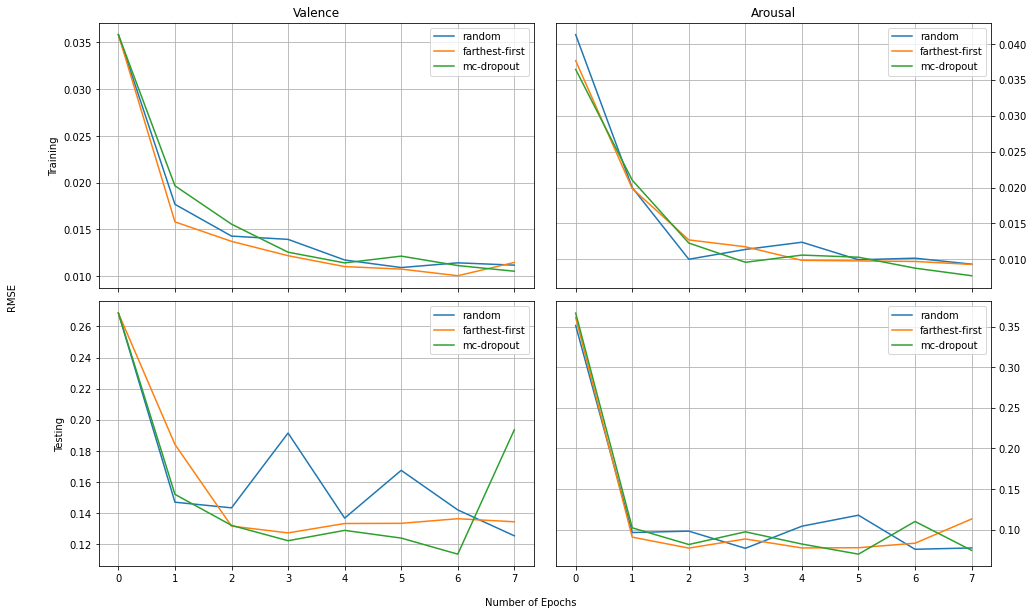

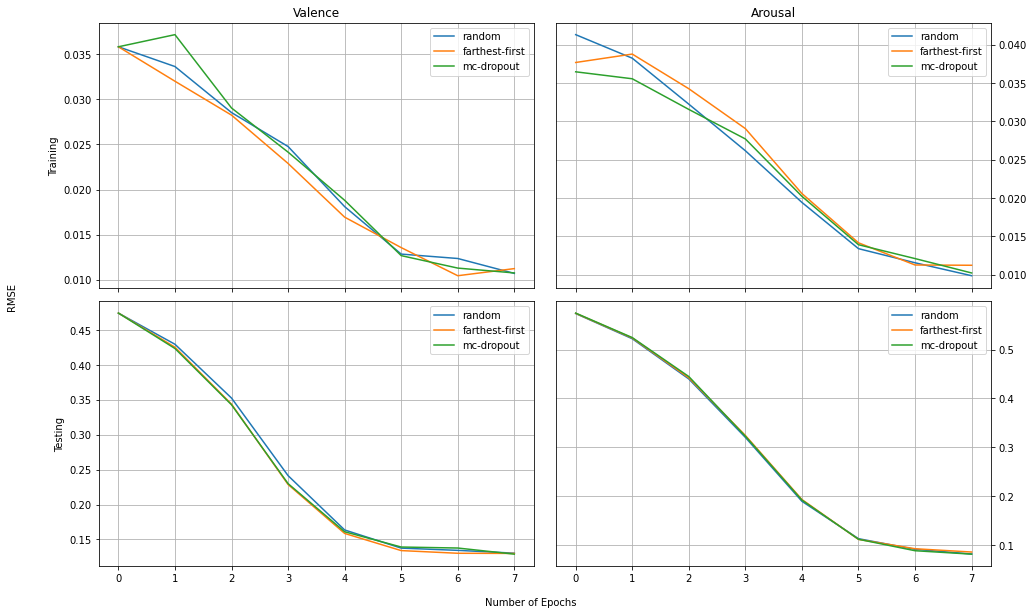

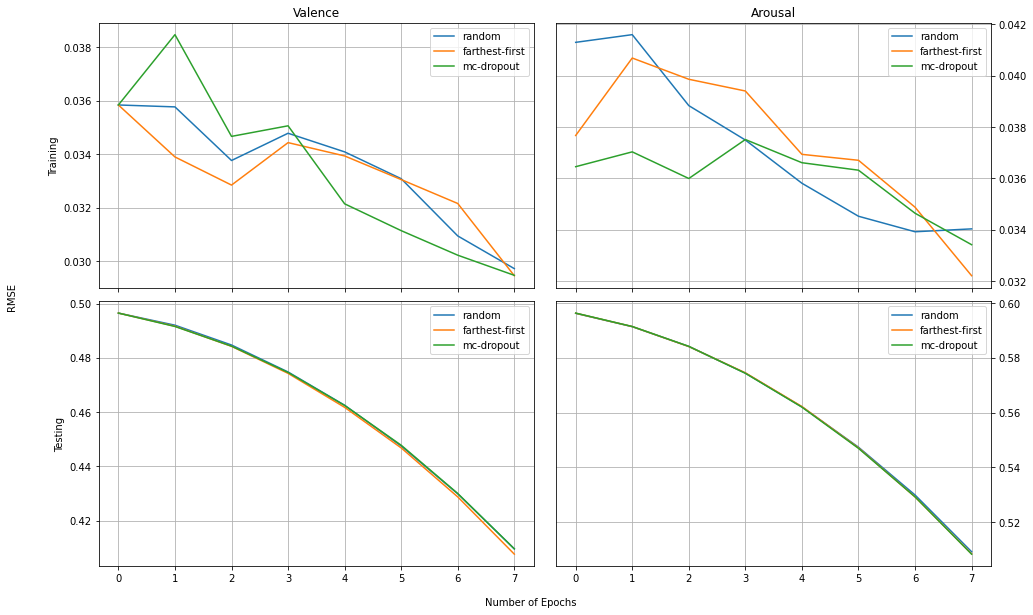

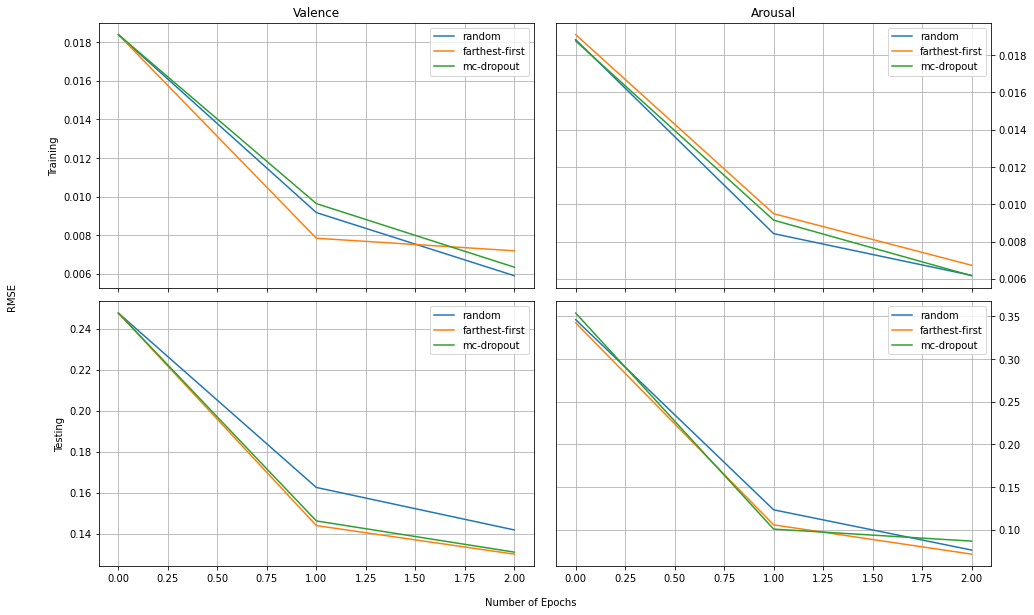

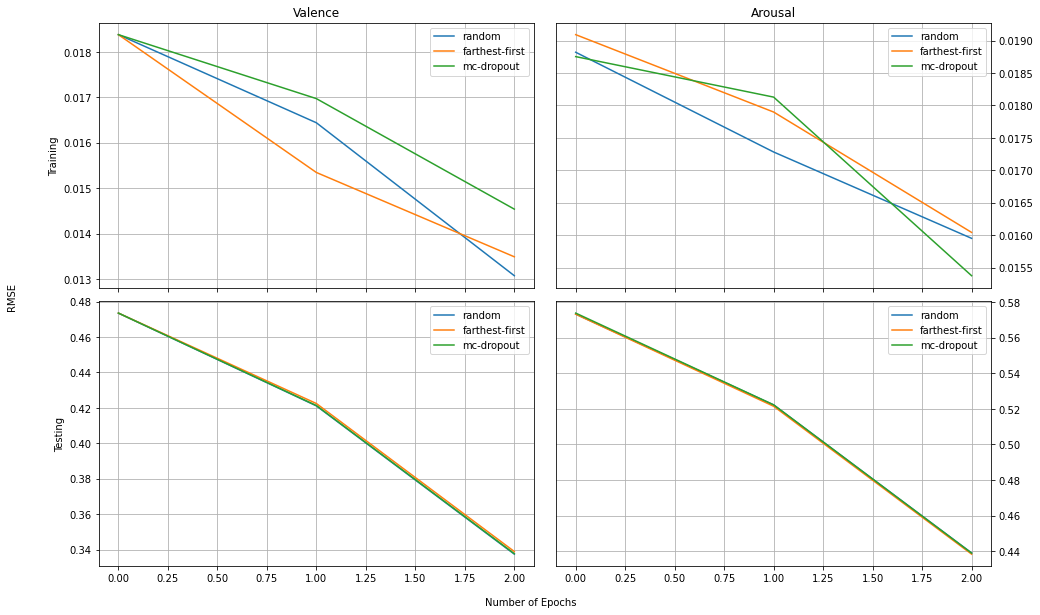

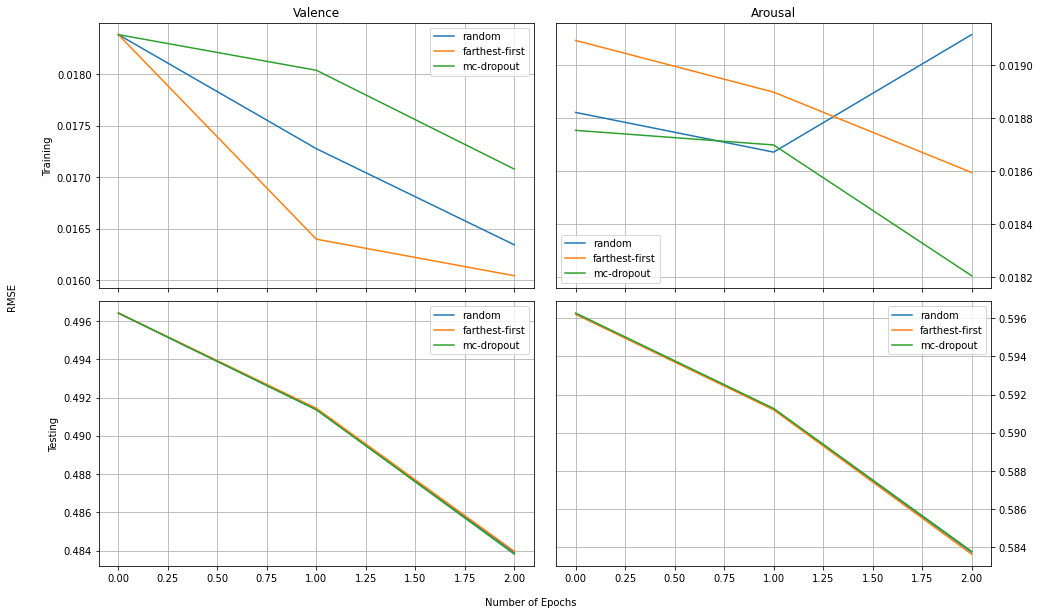

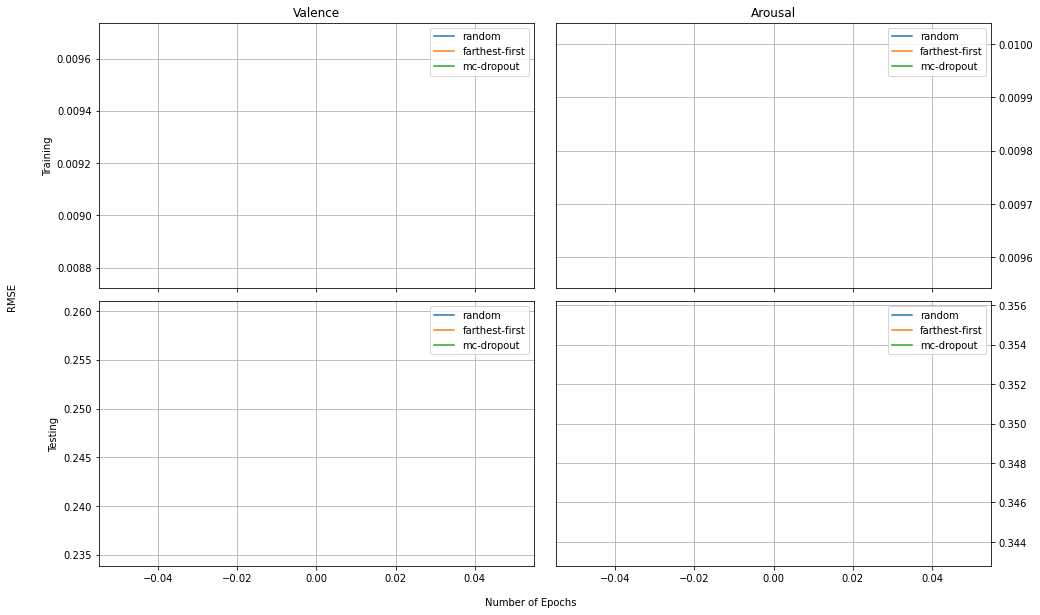

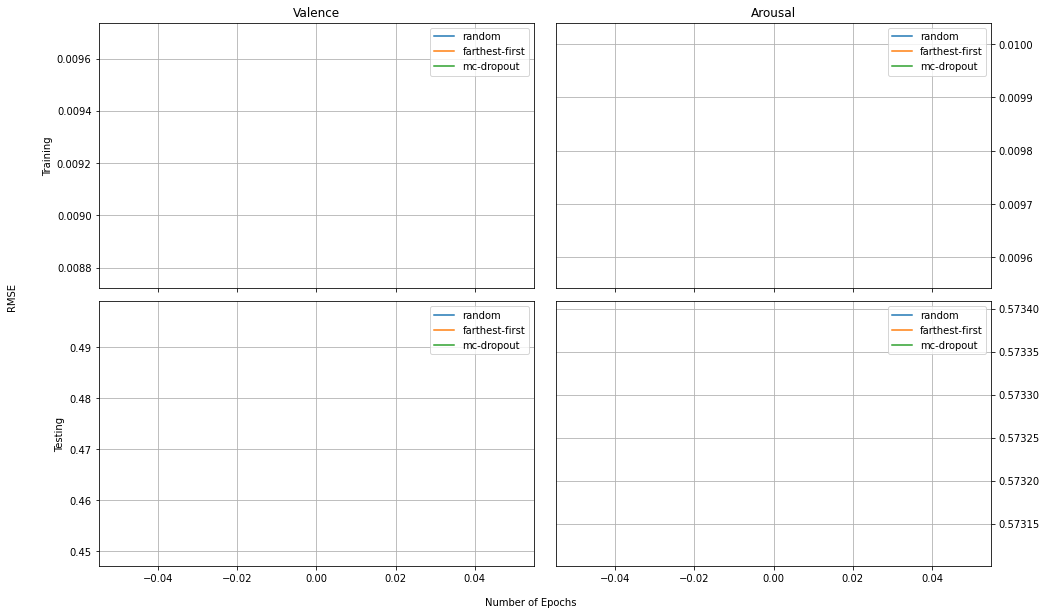

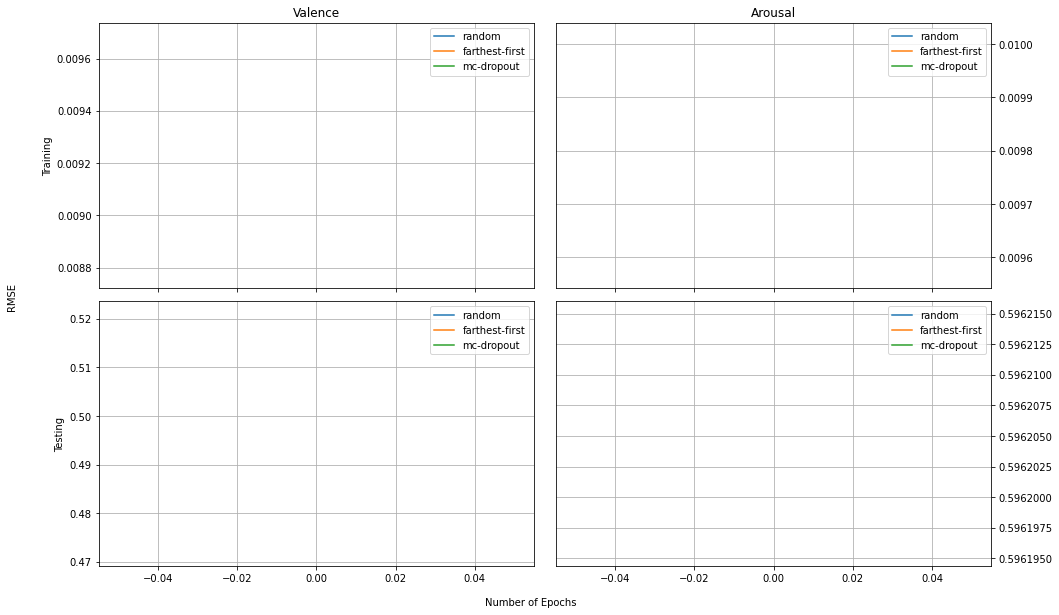

In [19]:
for batch_size in batch_sizes:
    for lr in lrs:
        plot_al_results(v_results, a_results, batch_size, lr)

In [21]:
v_results

{16: {1e-05: {'random': {'train': [0.03583666867944175,
     0.017684353029354914,
     0.014283838987339611,
     0.013935302465657476,
     0.011728451189812748,
     0.010919551185532317,
     0.011424113066548416,
     0.01117802369337279],
    'test': [0.26859298163156897,
     0.14710925557338,
     0.14349819956879198,
     0.19153737272747004,
     0.13688966661014523,
     0.16756581849991586,
     0.14217142438673835,
     0.12553515690601852]},
   'farthest-first': {'train': [0.03583666867944175,
     0.015805599179438048,
     0.013723252013717352,
     0.012187201903413106,
     0.011023798510384939,
     0.010754715230072098,
     0.010046510149120154,
     0.011467095892887259],
    'test': [0.26859298163156897,
     0.1842039350762023,
     0.13176132050530093,
     0.12739214554761935,
     0.13343432635740785,
     0.1335446869276533,
     0.13650503979161935,
     0.13454305234334493]},
   'mc-dropout': {'train': [0.03583666867944175,
     0.019663937566137053,
     

In [39]:
# function to structure the results

v_res_summ = {}

v_res_summ['random'] = []
v_res_summ['farthest-first'] = []
v_res_summ['mc-dropout'] = []

for key in v_results.keys():
    for subkey in v_results[key].keys():
        for method in v_results[key][subkey].keys():
            v_res_summ[method].append(np.mean(v_results[key][subkey][method]['test']))

In [40]:
v_res_summ

{'random': [0.1653624844880036,
  0.2579164221694412,
  0.4622178008718765,
  0.18403057372141562,
  0.41071081391552866,
  0.4905633145724069,
  0.2474260063214887,
  0.47308463219277663,
  0.49637724879428846],
 'farthest-first': [0.15624718602258963,
  0.25307888829628034,
  0.46147397005562607,
  0.17389181145990426,
  0.4116492626198062,
  0.490609980989269,
  0.2474260063214887,
  0.47308463219277663,
  0.49637724879428846],
 'mc-dropout': [0.15447933665272284,
  0.25463840354126704,
  0.4621215302004643,
  0.1749750634116328,
  0.41086406318882035,
  0.49053611064995123,
  0.2474260063214887,
  0.47308463219277663,
  0.49637724879428846]}

In [41]:
# make a table to summarize the results

idx_arrs = [
    [16, 16, 16, 32, 32, 32, 64, 64, 64],
    [1e-5, 1e-6, 1e-7, 1e-5, 1e-6, 1e-7, 1e-5, 1e-6, 1e-7]
    ]

idx_tuples = list(zip(*idx_arrs))

index = pd.MultiIndex.from_tuples(idx_tuples, names=["batch_size", "learning_rate"])

# construct the results dataframe

v_res_summ_df = pd.DataFrame(v_res_summ, index=index)


In [43]:
print(v_res_summ_df.to_latex())

\begin{tabular}{llrrr}
\toprule
   &              &    random &  farthest-first &  mc-dropout \\
batch\_size & learning\_rate &           &                 &             \\
\midrule
16 & 1.000000e-05 &  0.165362 &        0.156247 &    0.154479 \\
   & 1.000000e-06 &  0.257916 &        0.253079 &    0.254638 \\
   & 1.000000e-07 &  0.462218 &        0.461474 &    0.462122 \\
32 & 1.000000e-05 &  0.184031 &        0.173892 &    0.174975 \\
   & 1.000000e-06 &  0.410711 &        0.411649 &    0.410864 \\
   & 1.000000e-07 &  0.490563 &        0.490610 &    0.490536 \\
64 & 1.000000e-05 &  0.247426 &        0.247426 &    0.247426 \\
   & 1.000000e-06 &  0.473085 &        0.473085 &    0.473085 \\
   & 1.000000e-07 &  0.496377 &        0.496377 &    0.496377 \\
\bottomrule
\end{tabular}



C:\Users\sebastian.keil\AppData\Local\Temp\ipykernel_1692\3627641000.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(v_res_summ_df.to_latex())
